# Project Information

#### Data Source
http://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval)

#### Data Set Information
This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. 

This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values. 

#### Attribute Information

#### Problem Statement

# Self Organizing Map

#### Data Preprocessing

In [15]:
# Importing the libraries
import numpy as np
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('Credit_Card_Applications.csv')
# Here the data is split to X and y not as features and label. Instead, its just to analyze later if a fraudulent application 
# is approved and vice-versa
# We will only use X afterwards in our SOM model
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Feature Scaling
# Using Normalization technique for feature scaling
# As long as we are using the sigmoid function at the output layer of ANN, its recommended to use normalised scaler
# instead of standard scaler
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

#### Training the SOM

In [16]:
# MiniSom class was referenced from https://testpypi.python.org/pypi/MiniSom/1.0
from minisom import MiniSom

# creating som object
som = MiniSom( x = 10, y = 10,
              # making 10X10 grid. Needs to be chosen based on the dataset we are processing(specially number of i/p variables)
              input_len = 15, # number of features(in X not in original dataset as we are excluding class column)
              sigma = 1, # radius of the neighnourhood in the grid
              learning_rate = 0.5, # hyperparameter candidate
              decay_function = None # option to speed up the convergence
)
# Initializing the weights()random initialization
som.random_weights_init(X)
# Trainign the SOM on X
som.train_random(data = X, num_iteration = 100)

#### Visualizing the Results

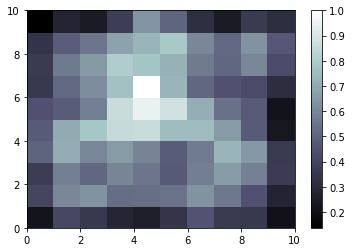

In [17]:
# Plotting the trained SOM itself
# mean of the distances of all neurons around the 'winning node' inside the neighbourhood we define

from pylab import bone, pcolor, colorbar, plot, show
# Initializing the figure
bone()
# putting different winning node in the map
pcolor(som.distance_map().T) # return a matrix containing all the mean neuron distances for all the winning nodes
# adding the legend of the colors
colorbar()
show()

The white blocks(largest mean neuron distance because white represents 1(max mean neuron distance)) represents the potential fraud. 

We can add some marker to make a distiction between approved and non-approved customers. i.e customers who cheated and got approved are mroe dangerous than the customers whose applicaiions were denied.

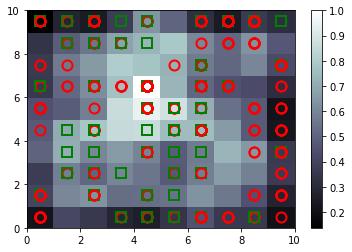

In [18]:
bone()
pcolor(som.distance_map().T)
colorbar()
# adding the markers
# red represents the customers who didn't get approval
# green represnts the customers who got the approval
markers = ['o', 's'] # marker shape
colors = ['r', 'g'] # marker color
# looping over all the customers and each customer will get a winning node apply the colormap 
# based on whether the customer get approval or not
for i, x in enumerate(X): # i is the looping the value, x is the actual customer vector
    w = som.winner(x)# fining the winning node for specific customer
    # 'winner' method returns the x & y coordinate of the winning node
    # plotting the marker
    plot(w[0] + 0.5, w[1] + 0.5, # coordinate of markers(center of the winning node)
         # since 'winner' return s the lower-left corner of the winning node, we want to add 0.5 to make it to the center
         markers[y[i]], # y specifies whether a customer got approval or not
         # y[i] returns either 0 or 1(whether a customer is approved or not) 
         # and then marker shape is applied based on the returned value
         markeredgecolor = colors[y[i]], # color of the marker is applied just like the shape of the marker
         markerfacecolor = 'None', # coloring only the edge
         markersize = 10,
         markeredgewidth = 2         
    )    
show()

#### Finding the Frauds

In [19]:
# Using the SOM to catch the fraud applicants
# Explicit list of customers who potentially cheated
mappings = som.win_map(X) # getting the mappings(mapping between winning node and customer)
# returns a dictionary of all the mappings from winning node to customers

In [22]:
# Finding the white pixels in the map
mapping = som.distance_map().T
all_coordinates = {}
i_counter = 0
for i in mapping:
    counter_x = 0
    for x in i:
        value = x
        coordinate = (counter_x,i_counter)
        all_coordinates[coordinate] = value
        counter_x += 1
    i_counter += 1
white = []
for x in all_coordinates.keys():
    if all_coordinates[x] >= 0.95: # thereshold of whiteness
        white.append(x)

print(white)

[(4, 6)]


In [23]:
frauds = mappings[(4,6)]
# need to concatenate all white coordinates if there are more than one white blocks
# i.e np.concatenate((mappings[1st coordinate], mappings[2nd coordinate] and so on), axis = 0)

In [24]:
# this results the scaled customer info
# applying inverse transform to get the original values
frauds = sc.inverse_transform(frauds)

# Artificial Neural Net

#### Creating Matrix of Feature for ANN Model

In [25]:
customers = dataset.iloc[:, 1:].values # everything except customerID

#### Creating the Dependent Variable
Here the dependent variable is created using the information we gained from the SOM part

In [26]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i, 0] in frauds: # checking each customers if they belog to list of fraud and assigining 1 if they did
        is_fraud[i] = 1

In [27]:
# Feature scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

#### Building ANN

In [28]:
# Importing Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initializing the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
# we will have 15 input nodes(for 15 independent variables)
# The best activation function could be rectifier function for the hidden layer and sigmoid function for the output layer
# We will also be able to find the rank of probability that customer is fraudulent
classifier.add(Dense(output_dim = 6,# number of nodes in the hidden layer being added. 
                     # Usual practice is to take an average of number of layers in i/p layer and o/p layers. 
                     # Or performance tuning by K-fold cross validation 
init = 'uniform' , # initialize the weights to small number close to 0
activation = 'relu', # rectifier activation function for hidden layer
input_dim = 15 # number of nodes in th i/p layer( # of independent variable)
)) # all the NN parameters are defined here

# Adding the output layer
classifier.add(Dense(output_dim = 1, # since we are expecting binary output, we need 1 output node. 
init = 'uniform', 
activation = 'sigmoid' # sigmoid activation function for output layer
# for muti-value output categories, we need output_dim = number of categories and activation = 'soft_max'
# soft_max is similar to sigmoid function but applied to dependent varibale that has more than 2 categories
)) 

# Compiling the ANN
# Applying stochastic gradient descent in the entire NN
classifier.compile(
optimizer = 'adam', # algorithm to find optimal set of weights for NN
loss = 'binary_crossentropy', # loss function within the stochastic gradient descent algorithm (i.e. in 'adam' algorithm
# binary_crossentropy -> for binary o/p and categorical_crossentropy -> for categorical o/p
metrics = ['accuracy'] # accuracy criterion to evaluate the model
)

# Fitting the ANN to the Training set
classifier.fit(customers, is_fraud, 
batch_size = 1, # whether to update the weights after each observation or after a batch of obobservation ckpropagation
nb_epoch = 10 # defines number of iterations
# for both batch_size and nb_epoch, no optimal value by default. Need to find the best value by experimentation 
# or performance tuning
)

Using TensorFlow backend.

#### Predicting the Fraud Probabilities

In [29]:
y_pred = classifier.predict(customers)
# combining the customer ID and predicted probability
y_pred = np.concatenate((dataset.iloc[:, 0:1], y_pred), axis = 1) # dataset.iloc[:, 0:1] = customerID
# indexing 0:1 gives 2D array instead of a vector
# sorting the customers based on probability of fraud
y_pred = y_pred[y_pred[:, 1].argsort()]

In [30]:
y_pred

array([[  1.57684740e+07,   3.83975324e-10],
       [  1.55946510e+07,   1.30214450e-09],
       [  1.57064640e+07,   4.29174252e-09],
       ..., 
       [  1.57565380e+07,   5.32821119e-01],
       [  1.55938340e+07,   5.32821119e-01],
       [  1.56605280e+07,   5.32821119e-01]])